In [ ]:
import spacy
import numpy as np 
import pandas as pd 
import os
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
candidate_sentences= pd.read_csv('test.csv')

In [ ]:
candidate_sentences.head()

,question,sql
0,What is terrence ross' nationality,SELECT Nationality FROM table WHERE Player = Terrence Ross
1,What clu was in toronto 1995-96,SELECT School/Club Team FROM table WHERE Years in Toronto = 1995-96
2,which club was in toronto 2003-06,SELECT School/Club Team FROM table WHERE Years in Toronto = 2003-06
3,how many schools or teams had jalen rose,SELECT COUNT School/Club Team FROM table WHERE Player = Jalen Rose
4,Where was Assen held?,SELECT Round FROM table WHERE Circuit = Assen


In [ ]:
nlp = spacy.load('en_core_web_sm')


In [ ]:
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")
for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [ ]:
pd.set_option('display.max_colwidth', 200)


In [ ]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
               ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]


In [ ]:
Entities=get_entities("Hi How are you")


In [ ]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [ ]:
get_relation("John completed the task")


'completed'

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["question"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 15878/15878 [02:34<00:00, 102.94it/s]


In [ ]:
entity_pairs[10:20]

[['players', 'Jersey Devils New Jersey Devils'],
 ['pick number pick number', ''],
 ['nationality', 'Vancouver Canucks Vancouver Canucks'],
 ['pick number pick number', 'Springfield Olympics Springfield Olympics'],
 ['that', 'september'],
 ['', 'december'],
 ['', 'september'],
 ['that', 'october'],
 ['spanish  coronel', 'commonwealth military commonwealth military'],
 ['officer titles officer that', 'group captain group english']]

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['question'])]

100%|██████████| 15878/15878 [02:29<00:00, 105.87it/s]


In [ ]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df[0:20]

,source,target,edge
0,terrence ross terrence nationality,,is
1,clu,toronto,was in
2,club,toronto,was in
3,jalen,,had
4,Where Assen,,held
...,...,...,...
15873,Alfa Romeo Team Alfa Romeo,many points,have
15874,chassis,39 points,had
15875,Ford V8 Ford V8,Tyrrell,have
15876,Ford V8 Ford V8,12 chassis,have


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12487 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26898 missing from current font.
  font.set_

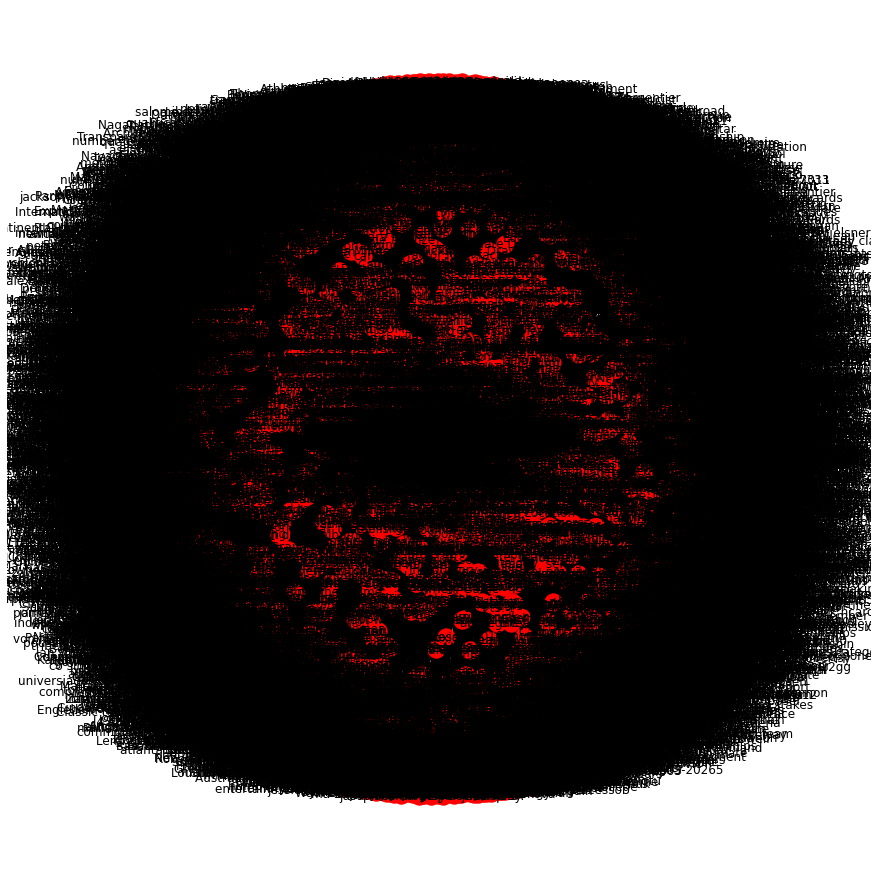

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df[0:20]

,source,target,edge
0,terrence ross terrence nationality,,is
1,clu,toronto,was in
2,club,toronto,was in
3,jalen,,had
4,Where Assen,,held
5,Kevin Curtain Kevin Curtain,that,was
6,date,Misano,was
7,Sherbrooke Faucons Sherbrooke Faucons,draft,provide in
8,nationalities,Bay Flyers Thunder Bay Flyers,are
9,club teams club teams,NHL Team Capitals NHL Team,provided


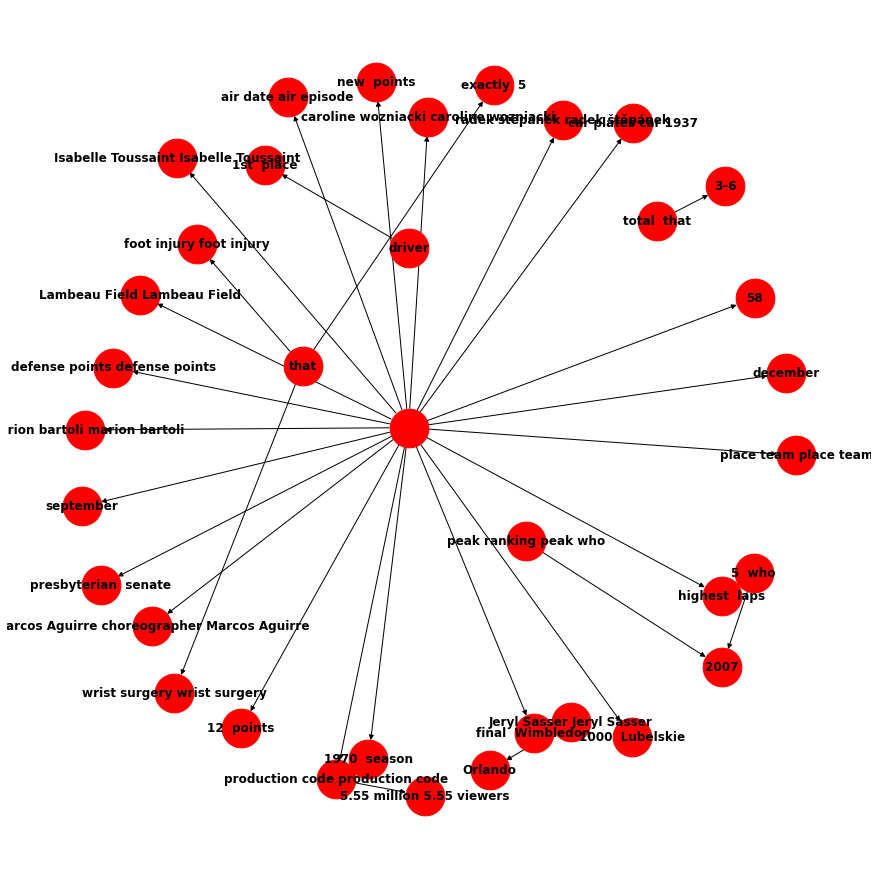

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="List"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()